# Initialize Connection Weights

After a neural network is constructed, the connection weights of different layers should be initialized. The ``brainpy.training.initialize`` module provides some build-in initializers that can be used for weight initialization. Here we will talk about how to use these initializers and how to create your customized initializers.

**Contents**

- [General structure of initializers](#General-structure-of-initializers)
- [Build-in regular initializers](#Build-in-regular-initializers)
- [Build-in random initializers](#Build-in-random-initializers)
- [Build-in decay initializers](#Build-in-decay-initializers)
- [Customize your initializers](#Customize-your-initializers)

## General structure of initializers

Initializers initialize the coonection weights between two groups of neurons (though they can refer to the same group). The base class of initializers are `brainpy.training.initialize.Initializer`. All initializers, build-in or costumized, should inherit the `Initializer` class. Besides, an initializer functions when it is called, so weight initialization should be implemented in the `__call__` function. The `__call__` function has a `shape` parameter as its input, which refers to the size of presynaptic and postsynaptic neurons or the shape of the neural population within wich self-connection weights are initialized.

In [59]:
import brainpy as bp
from brainpy.training import initialize

import numpy as np
import matplotlib.pyplot as plt

bp.math.set_platform('cpu')

# visualization
def mat_visualize(matrix, cmap=plt.cm.get_cmap('coolwarm')):
    im = plt.matshow(matrix, cmap=cmap)
    plt.colorbar(mappable=im, shrink=0.8, aspect=15)
    plt.show()

## Build-in regular initializers

There are `ZeroInit`, `OneInit`, and `Identity` initializers in build-in regular initializers. It is supposed that the presynaptic layer and the postsynpatic layer is fully connected. When calling the initializer, a 2-D shape should be input that refers to the number of presynaptic and postsynaptic neurons $(n_{pre}, n_{post})$. After calling, it returns a `brainpy.math.jaxarray.JaxArray` of the input `shape`, where the value at $(i, j)$ is the initialized connection weight of presynaptic neuron $ i $ and postsynpatic neuron $ j $.

Here we show how to use the `OneInit` initializer. The remaining two classes are used in a similar way. See ``brainpy.training.initialize`` for more details.

### brainpy.training.initialize.OneInit

This initializer initializes all the weights with the same given value. In the following example, 5 presynaptic neurons are fully connected to 6 postsynaptic neurons with the same weight value:

In [113]:
shape = (5, 6)
one_init = initialize.OneInit(value=2.5)
weights = one_init(shape)
print(weights)

JaxArray(DeviceArray([[2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                      [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                      [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                      [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                      [2.5, 2.5, 2.5, 2.5, 2.5, 2.5]], dtype=float32))


## Build-in random initializers

There are `Normal`, `Uniform`, `Orthogonal` and other initializers in build-in regular initializers. It is supposed that the presynaptic layer and the postsynpatic layer is fully connected. When calling the initializer, a 2-D shape should be input that refers to the number of presynaptic and postsynaptic neurons $(n_{pre}, n_{post})$. After calling, it returns a `brainpy.math.jaxarray.JaxArray` of the input `shape`, where the value at $(i, j)$ is the initialized connection weight of presynaptic neuron $i$ to postsynpatic neuron $j$.

Here we show how to use the `Normal` initializer. See ``brainpy.training.initialize`` for more details.

### brainpy.training.initialize.Normal

This initializer initializes the weights with a normal distribution. The variance of the distribution changes according to the `scale` parameter. In the following example, 10 presynaptic neurons are fully connected to 20 postsynaptic neurons with the same weight value:

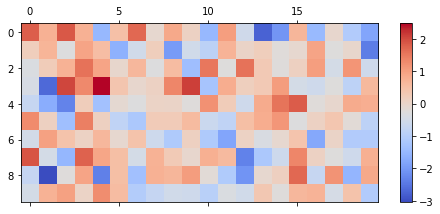

In [94]:
shape = (10, 20)
normal_init = initialize.Normal(scale=1.0)
weights = normal_init(shape)
mat_visualize(weights)

## Build-in decay initializers

There are `GaussianDecay` and `DOGDecay` initializers in build-in regular initializers. Below are examples of how to use them in weight initialization. **For decay initializers, because the decay pattern is built within a group of neurons, the input `shape` refers to the structure of the neural population, which is different from the that in the previous two types of initializers.** The `__call__` function returns an 2-D array regardless of the dimension of the neural population matrix. In the 2-D array, the value at $(i, j)$ is the initialized connection weight of neuron $i$ to neuron $j$ at position $i$ and $j$, respectively, of the flattened neural sequence.

### brainpy.training.initialize.GaussianDecay

This initializer builds a Gaussian connectivity pattern within a population of neurons, where the weights decay with a gaussian function.
Specifically, for any pair of neurons $ (i, j) $, the weight is computed as

$$
w(i, j) = w_{max} \cdot \exp(-\frac{\sum_{k=1}^n |v_k^i - v_k^j|^2 }{2\sigma^2})
$$

where $ v_k^i $ is the $ i $-th neuron's encoded value (position) at dimension $ k $.

The example below is a neural population with the size of $ 5 \times 5 $. Note that this shape is the structure of the target neural population, not the size of presynaptic and postsynaptic neurons.

In [104]:
size = (5, 5)
gaussian_init = initialize.GaussianDecay(sigma=2., max_w=10., include_self=True)
weights = gaussian_init(size)
print('shape of weights: {}'.format(weights.shape))

shape of weights: (25, 25)


Self-connections are created if `include_self=True`. The connection weights of each neuron with others are stored in each row of `weights`. For instance, the connection weights of neuron(0, 0) with others are stored in `weights`[0]. After reshaping, the weights are:

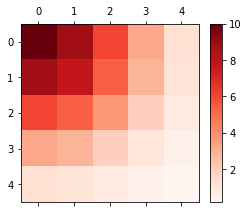

In [106]:
mat_visualize(weights[0].reshape(size), cmap=plt.cm.get_cmap('Reds'))

### brainpy.training.initialize.DOGDecay

This initializer builds a Difference-Of-Gaussian (DOG) connectivity pattern within a population of neurons. Specifically, for the given pair of neurons $ (i, j) $, the weight between them is computed as

$$
w(i, j) = w_{max}^+ \cdot \exp(-\frac{\sum_{k=1}^n |v_k^i - v_k^j|^2}{2\sigma_+^2}) - w_{max}^- \cdot \exp(-\frac{\sum_{k=1}^n |v_k^i - v_k^j|^2}{2\sigma_-^2})
$$

where $ v_k^i $ is the $ i $-th neuron's encoded value (position) at dimension $ k $.

<img src="../_static/DOGDecay.png" width="200 px">

The example below is a neural population with the size of $ 10 \times 10 $:

In [107]:
size = (10, 10)
gaussian_init = initialize.DOGDecay(sigmas=(1., 3.), max_ws=(10., 5.), min_w=0.1, include_self=True)
weights = gaussian_init(size)
print('shape of weights: {}'.format(weights.shape))

shape of weights: (100, 100)


Weights smaller than `min_w` will not be created. `min_w` $ = 0.005 \times min( $ `max_ws` $ ) $ if it is not assigned with a value.
The organization of `weights` is similar to that in the `GaussianDecay` initializer. For instance, the connection weights of neuron (3, 4) with others after reshaping are shown as below:

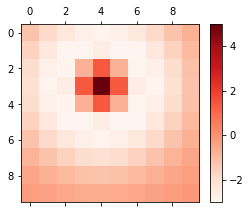

In [108]:
mat_visualize(weights[34].reshape(size), cmap=plt.cm.get_cmap('Reds'))

## Customize your initializers

BrainPy also allows users to customize the weight initializers of their own. When customizing a initializer, users should follow the instructions below:
- Your initializer should inherit `brainpy.training.initialize.Initializer`.
- Override the `__call__` funtion, to which the `shape` parameter should be given.

Here is an example of creating an initializer that initialize the weights as follows:

$$
w(i, j) = max(w_{max} - \sigma |v_i - v_j|, 0)
$$

In [137]:
class LinearDecay(initialize.Initializer):
    def __init__(self, max_w, sigma=1.):
        self.max_w = max_w
        self.sigma = sigma
    
    def __call__(self, shape, dtype=None):
        mat = bp.math.zeros(shape, dtype=dtype)
        n_pre, n_post = shape
        seq = np.arange(n_pre)
        current_w = self.max_w
        
        for i in range(max(n_pre, n_post)):
            if current_w <= 0:
                break
            seq_plus = ((seq + i) >= 0) & ((seq + i) < n_post)
            seq_minus = ((seq - i) >= 0) & ((seq - i) < n_post)
            mat[seq[seq_plus], (seq + i)[seq_plus]] = current_w
            mat[seq[seq_minus], (seq - i)[seq_minus]] = current_w
            current_w -= self.sigma
        
        return mat

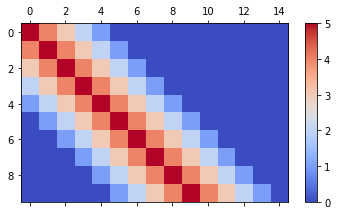

In [138]:
shape = (10, 15)
lin_init = LinearDecay(max_w=5, sigma=1.)
weights = lin_init(shape)
mat_visualize(weights)

---

- Xiaoyu Chen (c-xy17@tsinghua.org.cn)
- Update at 2021.12.02

---